Reference:
    https://www.tensorflow.org/tutorials/keras/regression

# 0. Load TensorFlow 2.0

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print("Current TensorFlow Version: \t", tf.__version__)
if (tf.__version__ != "2.0.0" and tf.__version__ != "2.0.0-beta1"):  
  !pip install tensorflow==2.0.0
  print("Upgrade TensorFlow Version: \t", tf.__version__)

Current TensorFlow Version: 	 2.0.0


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tensorflow import keras
from tensorflow.keras import layers

# 1. Data Preprocessing

## 1.1 Load DataSet

In [0]:
datasetPath = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
datasetPath

'/root/.keras/datasets/auto-mpg.data'

In [13]:
columnNames = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
df_DataSet_Raw = pd.read_csv(datasetPath, names=columnNames, na_values = "?",
                          comment='\t', sep=" ", skipinitialspace=True)
df_DataSet_Raw.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 1.2 Clean Data

In [17]:
print(df_DataSet_Raw.isna().sum(axis=0))
df_DataSet = df_DataSet_Raw.dropna()
print("df_DataSet_Raw Shape Before DropNA: \t\t", df_DataSet_Raw.shape)
print("df_DataSet     Shape After  DropNA: \t\t", df_DataSet.shape)
ss_Origin = df_DataSet.pop('Origin')
print("df_DataSet     Shape After  pop('Origin'): \t", df_DataSet.shape)

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64
df_DataSet_Raw Shape Before DropNA: 		 (398, 8)
df_DataSet     Shape After  DropNA: 		 (392, 8)
df_DataSet     Shape After  pop('Origin'): 	 (392, 7)


In [18]:
df_DataSet['USA'] = (ss_Origin == 1)*1.0
df_DataSet['Europe'] = (ss_Origin == 2)*1.0
df_DataSet['Japan'] = (ss_Origin == 3)*1.0
print("New df_DataSet shape:\t", df_DataSet.shape)
df_DataSet.tail()

New df_DataSet shape:	 (392, 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## 1.3 Split into TrainingSet and TestSet

In [19]:
df_TrainingSet = df_DataSet.sample(frac=0.8,random_state=0)
df_TestSet  = df_DataSet.drop(df_TrainingSet.index)
print("df_DataSet shape:\t", df_DataSet.shape)
print("df_TrainingSet shape:\t", df_TrainingSet.shape)
print("df_TestSet shape:\t", df_TestSet.shape)

df_DataSet shape:	 (392, 10)
df_TrainingSet shape:	 (314, 10)
df_TestSet shape:	 (78, 10)


#1.4 Inspect the data

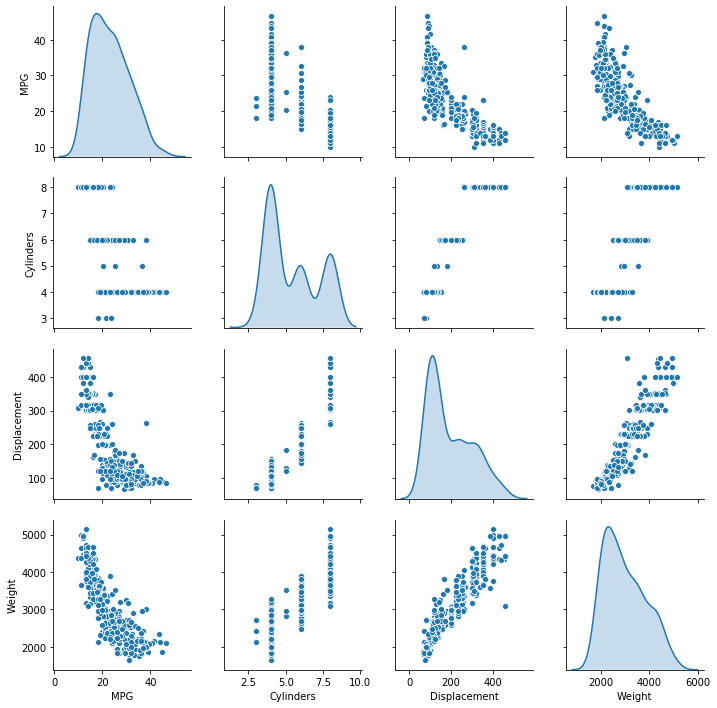

In [20]:
sns.pairplot(df_TrainingSet[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [21]:
df_Train_Stats = df_TrainingSet.describe()
df_Train_Stats.pop("MPG")
df_Train_Stats = df_Train_Stats.transpose()
df_Train_Stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


## 1.5 Split features from labels

In [22]:
ss_Train_Y = df_TrainingSet.pop('MPG')
ss_Test_Y = df_TestSet.pop('MPG')
print("ss_Train_Y shape:\t", ss_Train_Y.shape)
print("ss_Test_Y shape:\t", ss_Test_Y.shape)

ss_Train_Y shape:	 (314,)
ss_Test_Y shape:	 (78,)


## 1.6 Normalize the data
Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.


In [0]:
'''
Note: 
    Although we intentionally generate these statistics from only the training dataset,
        these statistics will also be used to normalize the test dataset! 
    We need to do that to project the test dataset into the same distribution 
        that the model has been trained on.
'''
def normalize(X, mean_TrainingSet, std_TrainingSet):
    return (X - mean_TrainingSet) / std_TrainingSet

In [24]:
normaized_Train_X = normalize(df_TrainingSet, df_Train_Stats['mean'], df_Train_Stats['std'])
normaized_Test_X = normalize(df_TestSet, df_Train_Stats['mean'], df_Train_Stats['std'])
print("df_Train_Stats['mean'] shape:\t", df_Train_Stats['mean'].shape)
print("normaized_Train_X shape:\t", normaized_Train_X.shape)
normaized_Train_X

df_Train_Stats['mean'] shape:	 (9,)
normaized_Train_X shape:	 (314, 9)


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,0.774676,-0.465148,-0.495225
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,0.774676,-0.465148,-0.495225
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-1.286751,-0.465148,2.012852
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-1.286751,-0.465148,2.012852


# 2. Keras Model
## 2.1 Build the model

In [0]:
'''
    use a Sequential model with two densely connected hidden layers, 
    Output layer that returns a single, continuous value
'''

def getTwoLayersSequential(sizeInput, strActication, layerNodesCount):
    model = keras.Sequential([
        layers.Dense(layerNodesCount, activation=strActication, input_shape=[sizeInput]),
        layers.Dense(layerNodesCount, activation=strActication),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model

In [26]:
features_X = df_TrainingSet.keys()
features_X

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

In [48]:
sizeInput = len(features_X)
print("NN Input size = \t", sizeInput)

modelSequential = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[sizeInput]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
optimizer = tf.keras.optimizers.RMSprop(0.001)
modelSequential.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

modelSequential.summary()

NN Input size = 	 9
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [29]:
!pip install GPUtil
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
print("GPUs numbers: \t", len(GPUs))
print("GPU name: \t", gpu.name)
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=1e1db40933baf2d494aaaaa7c84ef9671ab7e9ba8eda4865f3a669da57166ee5
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
GPUs numbers: 	 1
GPU name: 	 Tesla K80
GPU RAM Free: 11308MB | Used: 133MB | Util   1% | Total 11441MB


## 2.2 Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.



In [0]:
# Display training progress by printing a single dot for each completed epoch
class PrintEpochCompletedCount(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch == 0:
            print('\nEpoch Completed Count: \n', end='')
        elif (epoch + 1) % 100 == 0:
            print(epoch + 1)
        elif (epoch + 1) % 10 == 0:
            print(epoch + 1, end='\t')

In [49]:
SIZE_EPOCHS = 1000
VERBOSE_SILENT = 0

timeStart = time.time()

lossHistory = modelSequential.fit(normaized_Train_X, ss_Train_Y, epochs=SIZE_EPOCHS, \
        validation_split = 0.2, verbose=VERBOSE_SILENT,callbacks=[PrintEpochCompletedCount()])

timeEnd = time.time()
runtime = timeEnd - timeStart
print('Two Layer Sequential {} epoches RunTime is {:.4f}'.format(SIZE_EPOCHS, runtime/60)+' mins')


Epoch Completed Count: 
10	20	30	40	50	60	70	80	90	100
110	120	130	140	150	160	170	180	190	200
210	220	230	240	250	260	270	280	290	300
310	320	330	340	350	360	370	380	390	400
410	420	430	440	450	460	470	480	490	500
510	520	530	540	550	560	570	580	590	600
610	620	630	640	650	660	670	680	690	700
710	720	730	740	750	760	770	780	790	800
810	820	830	840	850	860	870	880	890	900
910	920	930	940	950	960	970	980	990	1000
Two Layer Sequential 1000 epoches RunTime is 0.6011 mins


In [50]:
tenHeadTestSetPredict = modelSequential.predict(normaized_Test_X[:10])
tenHeadTestSetPredict

array([[15.595378],
       [ 8.935755],
       [ 9.664727],
       [23.962431],
       [19.772842],
       [12.690029],
       [13.533195],
       [11.355146],
       [19.071815],
       [32.83645 ]], dtype=float32)

## 2.3 Visualize Loss History

In [51]:
df_LossHistory = pd.DataFrame(lossHistory.history)
df_LossHistory['epoch'] = lossHistory.epoch
df_LossHistory.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.447715,0.975344,2.447715,8.049093,2.154509,8.049093,995
996,2.493727,1.023321,2.493727,8.328532,2.194888,8.328532,996
997,2.629797,0.988027,2.629797,8.240900,2.186118,8.240900,997
998,2.499687,0.969288,2.499687,8.086346,2.194663,8.086347,998
999,2.607055,0.995583,2.607055,7.372538,2.081017,7.372538,999


In [0]:
def plot_LossHistory(lossHistory):
    df_LossHistory = pd.DataFrame(lossHistory.history)
    df_LossHistory['epoch'] = lossHistory.epoch

    plt.figure()
    plt.xlabel('Epoch'); plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(df_LossHistory['epoch'], df_LossHistory['mae'],     label = 'Train Error')
    plt.plot(df_LossHistory['epoch'], df_LossHistory['val_mae'], label = 'Val Error')
    plt.ylim([0,5]); plt.legend()

    plt.figure()
    plt.xlabel('Epoch'); plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(df_LossHistory['epoch'], df_LossHistory['mse'],     label = 'Train Error')
    plt.plot(df_LossHistory['epoch'], df_LossHistory['val_mse'], label = 'Val Error')
    plt.ylim([0,20]); plt.legend()
    plt.show()

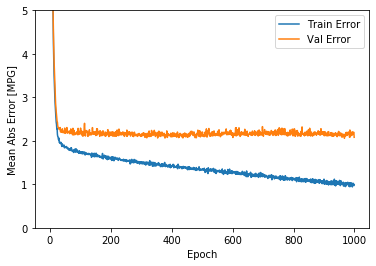

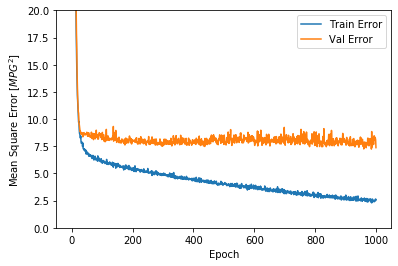

In [53]:
plot_LossHistory(lossHistory)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).

## 2.4 Early Stop


Epoch Completed Count: 
10	20	30	40	50	

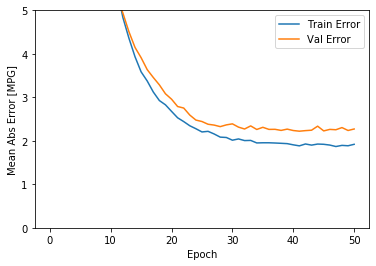

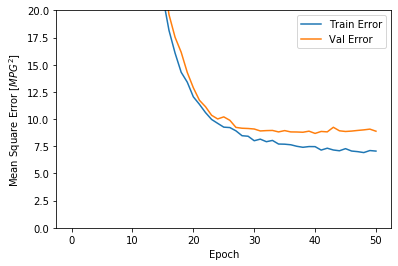

In [56]:
modelSequential = getTwoLayersSequential(sizeInput, 'relu', 64)

optimizer = tf.keras.optimizers.RMSprop(0.001)
modelSequential.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

# The patience parameter is the amount of epochs to check for improvement
earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

earlyStop_LossHistory = modelSequential.fit(normaized_Train_X, ss_Train_Y, epochs=SIZE_EPOCHS, \
    validation_split = 0.2, verbose=VERBOSE_SILENT,callbacks=[earlyStop, PrintEpochCompletedCount()])

plot_LossHistory(earlyStop_LossHistory)

## 2.5 Evaluate Model

In [57]:
loss, mae, mse = modelSequential.evaluate(normaized_Test_X, ss_Test_Y, verbose=2)

print("TestSet Mean Abs Error: {:5.2f} MPG".format(mae))

78/78 - 0s - loss: 6.0169 - mae: 1.8883 - mse: 6.0169
TestSet Mean Abs Error:  1.89 MPG


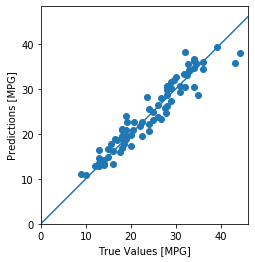

In [58]:
y_Test_Predict = modelSequential.predict(normaized_Test_X).flatten()

plt.scatter(ss_Test_Y, y_Test_Predict)
plt.xlabel('True Values [MPG]'); plt.ylabel('Predictions [MPG]')
plt.axis('equal'); plt.axis('square')
plt.xlim([0,plt.xlim()[1]]); plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts reasonably well.

Text(0, 0.5, 'Count')

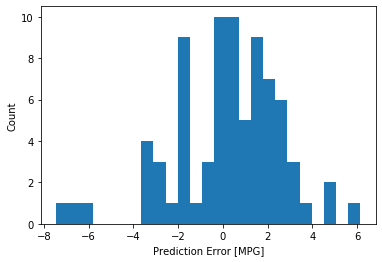

In [59]:
# look at the error distribution
ss_Error = y_Test_Predict - ss_Test_Y
plt.hist(ss_Error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.